# Side-By-Side Comparison of Synthetic vs. Real Data

In [1]:
#!pip install lightgbm==3.3
#!pip install shap

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import shap
shap.initjs()

## Read Data

In [3]:
base_url = ""  # "https://github.com/mostly-ai/public-demo-data/raw/dev/census/"
syn = pd.read_parquet(base_url + "acs-income-2018-synthetic.parquet")
trn = pd.read_parquet(base_url + "acs-income-2018-train.parquet")
hol = pd.read_parquet(base_url + "acs-income-2018-holdout.parquet")
print(f"read {syn.shape[0]:,} synthetic records")
print(f"read {trn.shape[0]:,} original records (train)")
print(f"read {hol.shape[0]:,} original records (holdout)")

read 1,180,974 synthetic records
read 1,180,974 original records (train)
read 295,243 original records (holdout)


## Train Models

In [4]:
def prepare_xy(df):
    tgt_col = 'Income'
    y = (df[tgt_col]>=50_000).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != tgt_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != tgt_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != tgt_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    print(f"X_trn: {X_trn.shape[0]:,} rows, {X_trn.shape[1]:,} columns, target: {y_trn.mean():.2%}")
    print(f"X_val: {X_val.shape[0]:,} rows, {X_val.shape[1]:,} columns, target: {y_val.mean():.2%}")
    model = lgb.train(
        num_boost_round=200, 
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5), log_evaluation(20)],
    )
    return model

def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    auc = roc_auc_score(y_hol, probs)
    probs_df = pd.concat([
        pd.Series(probs, name='probability').reset_index(drop=True),
        pd.Series(y_hol, name='target').reset_index(drop=True)
    ], axis=1)
    fig = sns.displot(data=probs_df, x='probability', hue='target', bins=20, palette=['#008CFB', '#FF004F'])
    fig = plt.title(f"Holdout ROC AUC: {auc:.3f}")

### Train-Synthetic-Test-Real

X_trn: 944,779 rows, 31 columns, target: 42.50%
X_val: 236,195 rows, 31 columns, target: 42.49%


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 5 rounds
[20]	valid_0's auc: 0.869917
[40]	valid_0's auc: 0.876753
[60]	valid_0's auc: 0.879183
[80]	valid_0's auc: 0.880055
[100]	valid_0's auc: 0.880383
Early stopping, best iteration is:
[108]	valid_0's auc: 0.880434


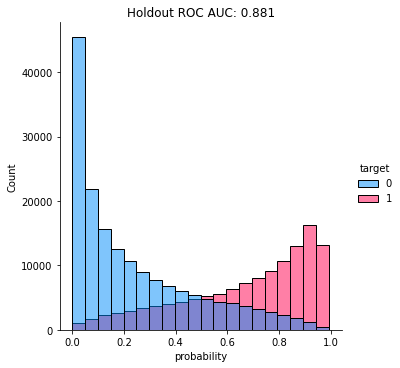

In [5]:
X_syn, y_syn = prepare_xy(syn)
model_syn = train_model(X_syn, y_syn)
evaluate_model(model_syn, hol)

### Train-Real-Test-Real

X_trn: 944,779 rows, 31 columns, target: 42.46%
X_val: 236,195 rows, 31 columns, target: 42.36%


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Training until validation scores don't improve for 5 rounds
[20]	valid_0's auc: 0.873146
[40]	valid_0's auc: 0.880908
[60]	valid_0's auc: 0.883666
[80]	valid_0's auc: 0.884984
[100]	valid_0's auc: 0.885521
[120]	valid_0's auc: 0.88578
[140]	valid_0's auc: 0.885969
Early stopping, best iteration is:
[143]	valid_0's auc: 0.885988


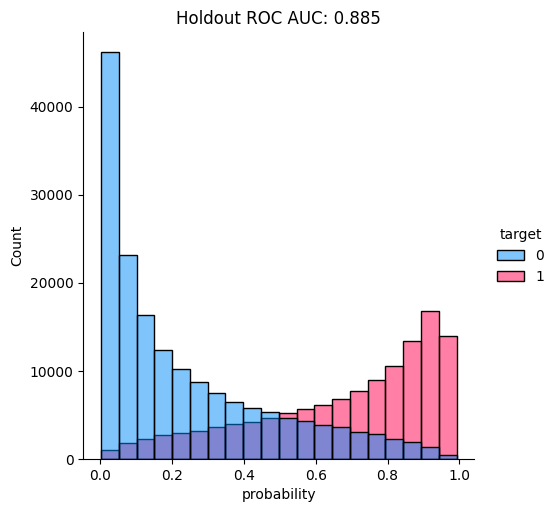

In [6]:
X_trn, y_trn = prepare_xy(trn)
model_trn = train_model(X_trn, y_trn)
evaluate_model(model_trn, hol)

## Explain Models

In [7]:
def show_idx(i):
    df = X_shap.iloc[i:i+1,:]
    top_n = 8
    cols = list(reversed(X_shap.columns[np.argsort(np.abs(shap_values[1][i,:]))[-top_n:]]))
    print(f"Customer:    {i}")
    print(f"Target:      {y_shap.iloc[i]}")
    print(f"Probability: {probs_shap[i]:.2%}")
    print("")
    print(f"##### Top {top_n} Attributes #####")
    print(df.iloc[0][cols])
    print("")
    return shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_shap.iloc[i,:], link="logit")

In [8]:
def plot_shap_dependency(col):
    col_idx = [i for i in range(X_shap.shape[1]) if X_shap.columns[i]==col][0]
    shp_vals = pd.Series(shap_values[1][:,col_idx], name='shap_value')
    col_vals = X_shap.iloc[:,col_idx].reset_index(drop=True)
    df = pd.concat([shp_vals, col_vals], axis=1)
    if col_vals.dtype.name != 'category':
        q01 = df[col].quantile(0.01)
        q99 = df[col].quantile(0.99)
        df = df.loc[(df[col] >= q01) & (df[col] <= q99), :]
    else:
        sorted_cats = list(df.groupby(col)['shap_value'].mean().sort_values().index)
        df[col] = df[col].cat.reorder_categories(sorted_cats, ordered=True)
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.ylim(-3.2, 3.2)
    if col_vals.dtype.name == 'category':
        plt.xticks(rotation = 90)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=6)
    p1 = sns.lineplot(x=df[col], y=df['shap_value'], color='black').axhline(0, color='gray', alpha=1, lw=0.5)
    p2 = sns.scatterplot(x=df[col], y=df['shap_value'], alpha=0.1)
    
def plot_shap_dependencies(max=20):
    top_features = list(reversed(X_shap.columns[np.argsort(np.mean(np.abs(shap_values[1]), axis=0))]))
    for col in top_features[:max]:
        print(col)
        plot_shap_dependency(col)    

### Train-Real-Explain-Real

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


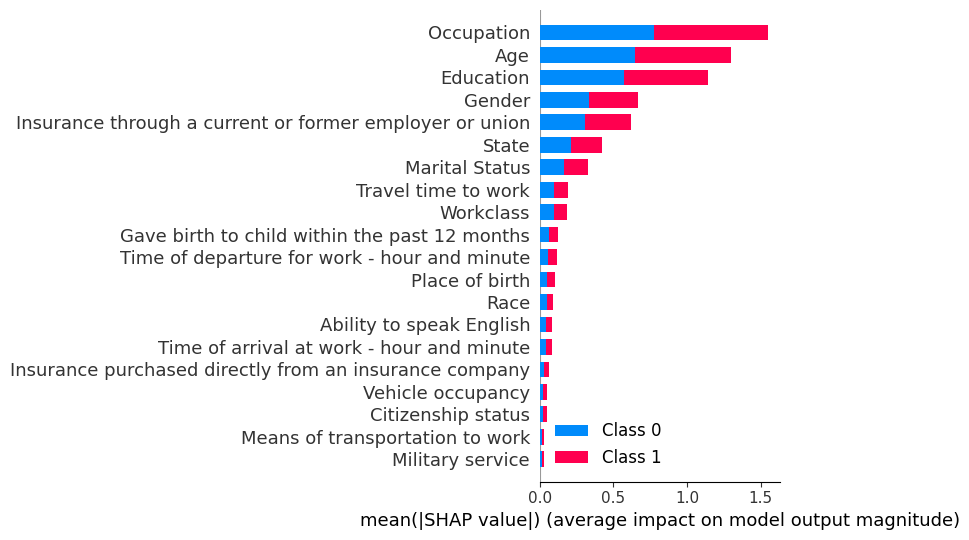

In [9]:
max_samples = 10_000
X_shap = X_trn.iloc[:max_samples]
y_shap = y_trn.iloc[:max_samples]
explainer = shap.TreeExplainer(model_trn)
shap_values = explainer.shap_values(X_shap)
probs_shap = model_trn.predict(X_shap)
shap.summary_plot(shap_values, X_shap, plot_size=0.2)

In [10]:
# sample with lowest probability
show_idx(np.argsort(probs_shap)[0])

Customer:    4031
Target:      0
Probability: 0.18%

##### Top 8 Attributes #####
Age                                                                                                18.0
Occupation                                                                                 SAL-Cashiers
Education                                                  1 or more years of college credit, no degree
Insurance through a current or former employer or union                                              No
Gender                                                                                           Female
Marital Status                                                      Never married or under 15 years old
Time of arrival at work - hour and minute                                        3:15 p.m. to 3:19 p.m.
Vehicle occupancy                                                                                   2.0
Name: 4031, dtype: object



In [11]:
# sample with highest probability
show_idx(np.argsort(probs_shap)[-1])

Customer:    5123
Target:      1
Probability: 98.73%

##### Top 8 Attributes #####
Occupation                                                        ENG-Aerospace Engineers
Education                                                                 Master's degree
Age                                                                                  62.0
State                                                                       California/CA
Gender                                                                               Male
Insurance through a current or former employer or union                               Yes
Marital Status                                                                    Married
Citizenship status                                         U.S. citizen by naturalization
Name: 5123, dtype: object



In [12]:
# random sample
show_idx(100)

Customer:    100
Target:      0
Probability: 7.39%

##### Top 8 Attributes #####
Occupation                                                                        OFF-Data Entry Keyers
Education                                                  1 or more years of college credit, no degree
Gender                                                                                           Female
Insurance through a current or former employer or union                                             Yes
Marital Status                                                      Never married or under 15 years old
Gave birth to child within the past 12 months                                                        No
State                                                                                           Ohio/OH
Vehicle occupancy                                                                                   2.0
Name: 100, dtype: object



In [13]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_shap.iloc[:1000,:], link="logit")

Occupation
Age
Education
Gender
Insurance through a current or former employer or union
State
Marital Status
Travel time to work
Workclass
Gave birth to child within the past 12 months
Time of departure for work - hour and minute
Place of birth
Race
Ability to speak English
Time of arrival at work - hour and minute
Insurance purchased directly from an insurance company
Vehicle occupancy
Citizenship status
Means of transportation to work
Military service


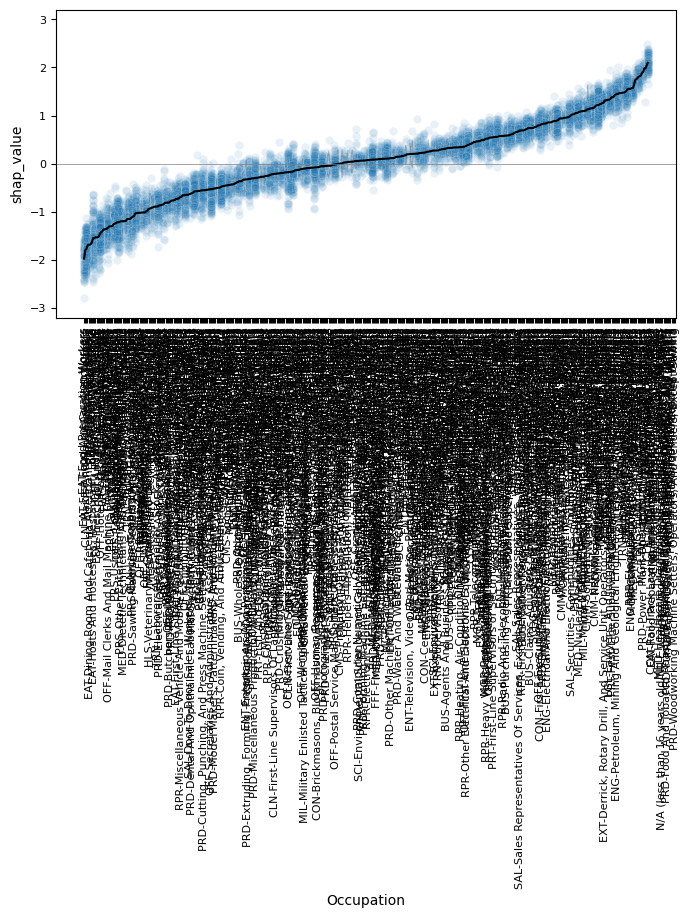

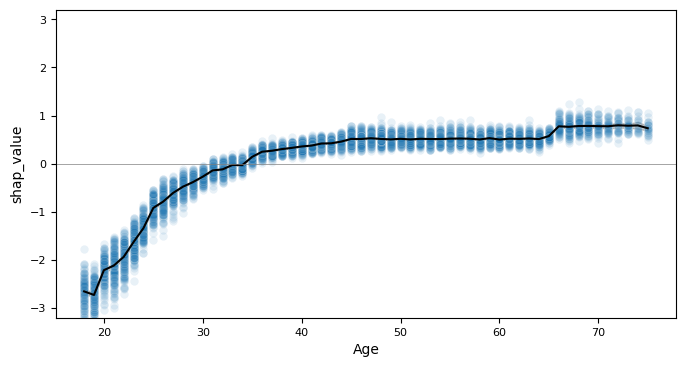

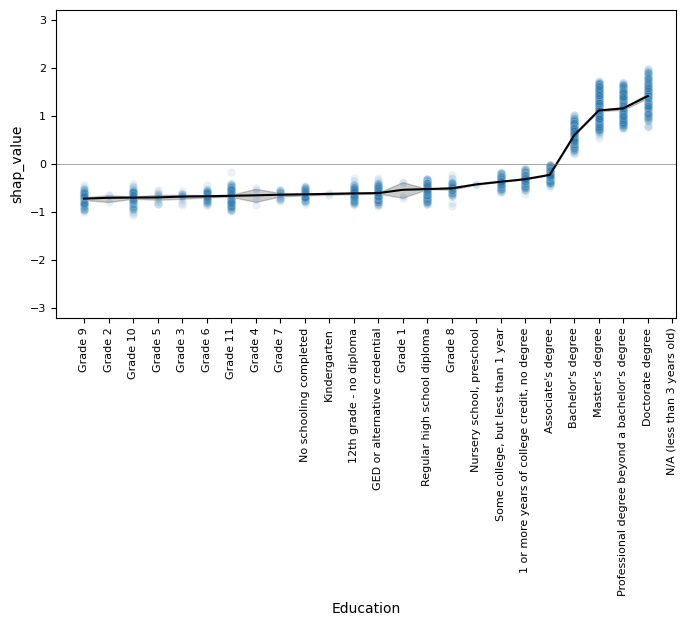

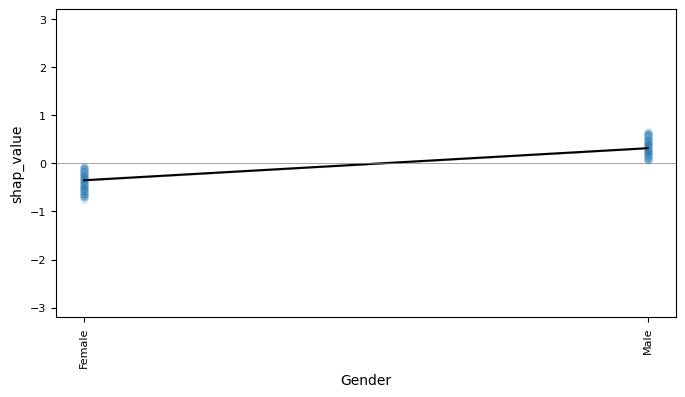

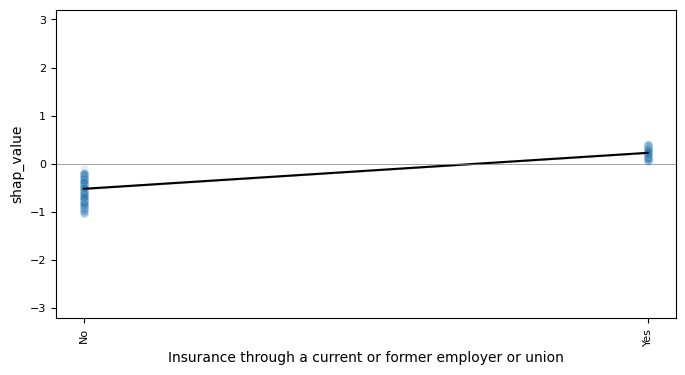

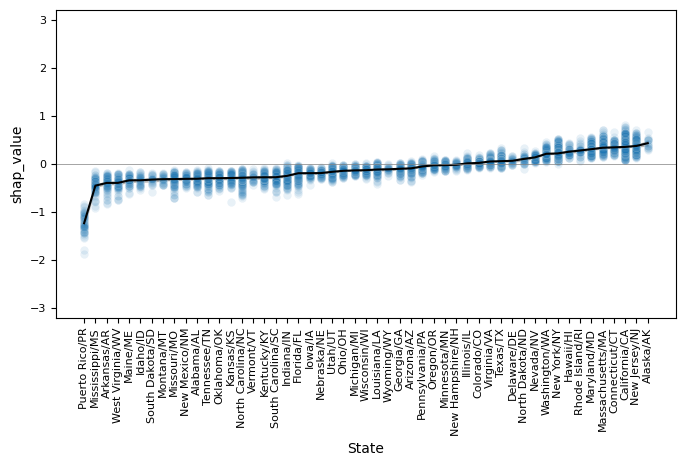

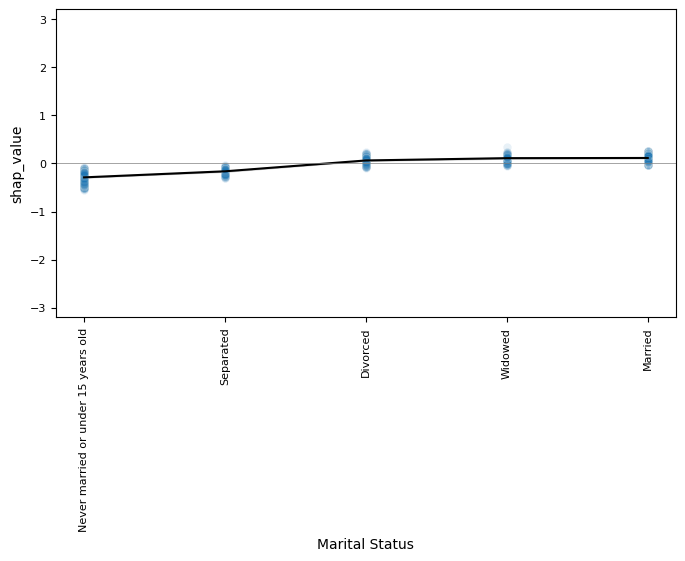

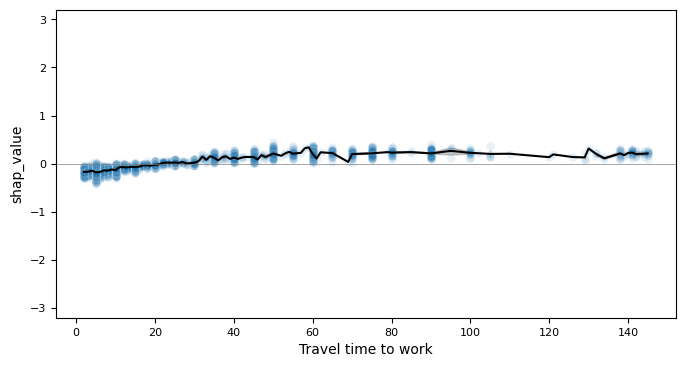

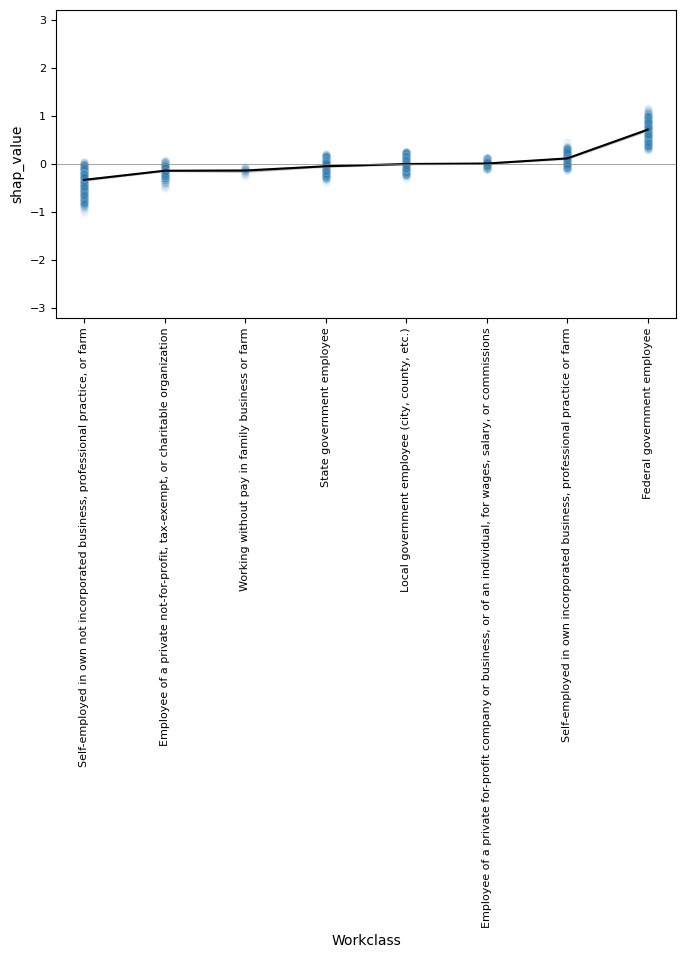

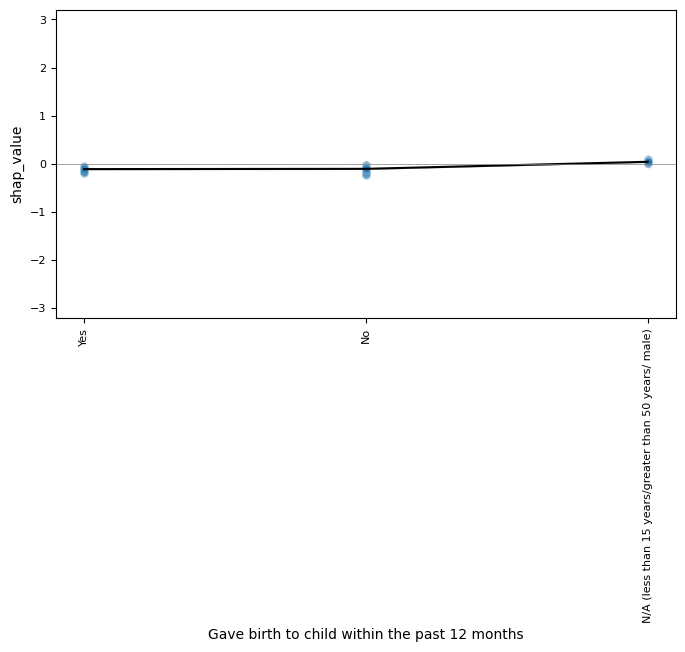

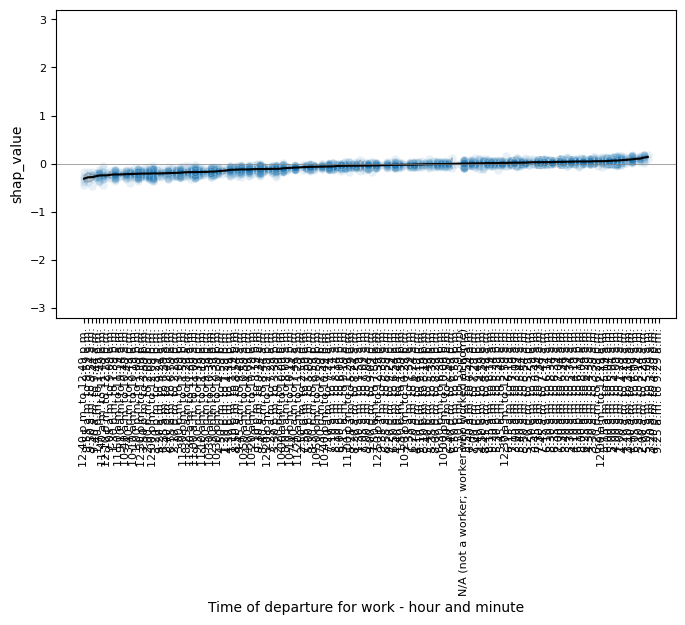

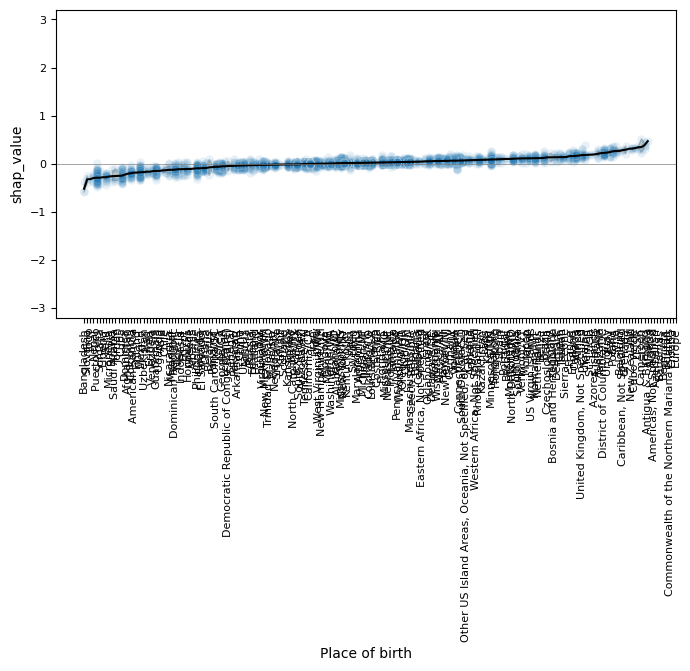

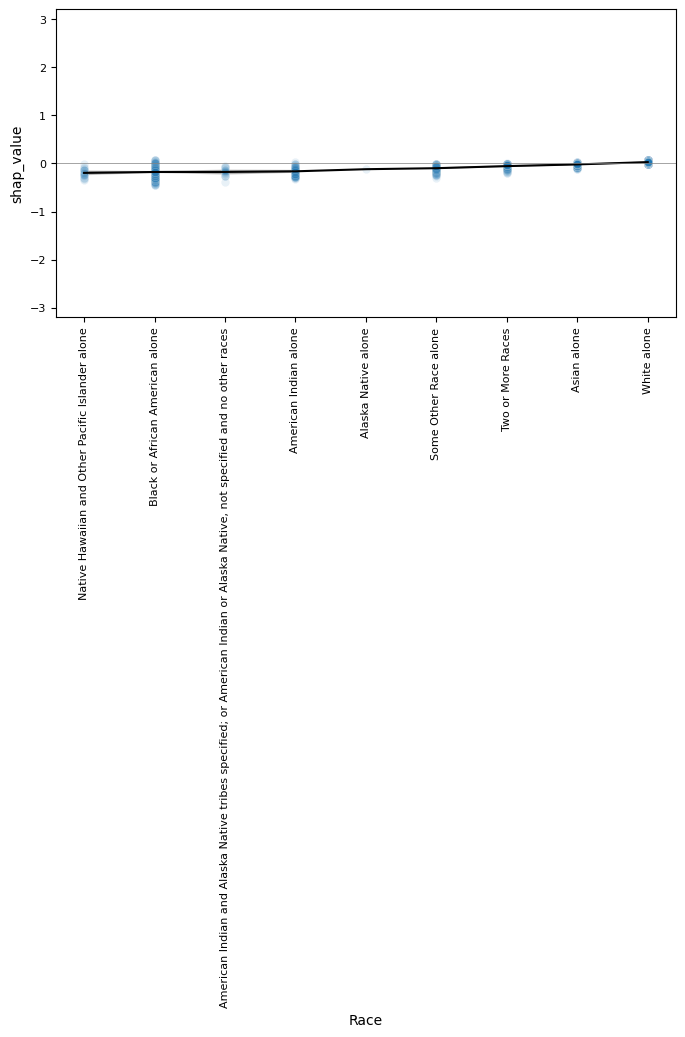

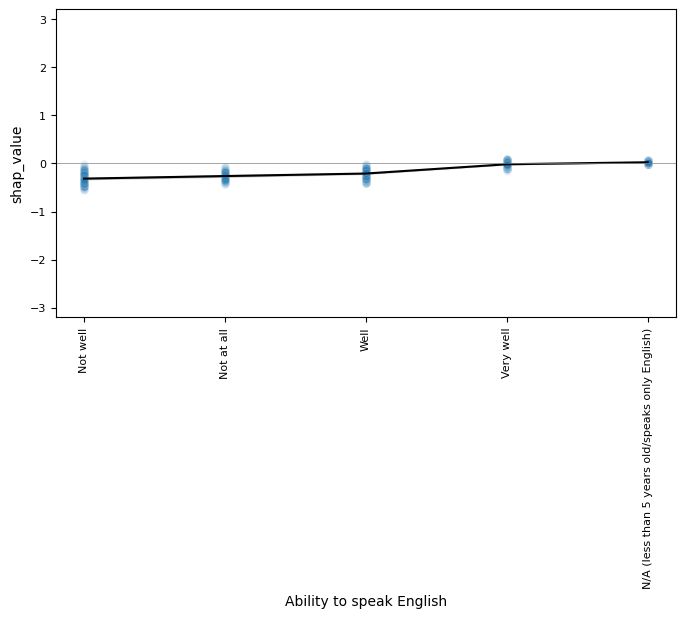

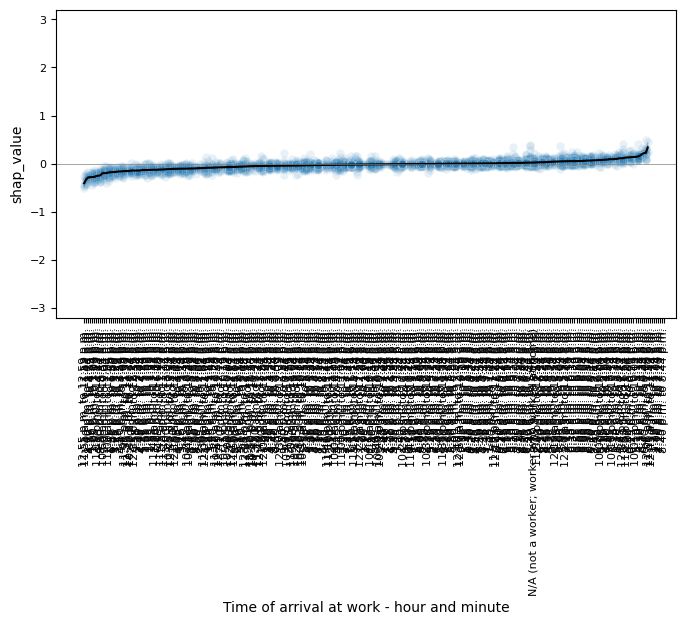

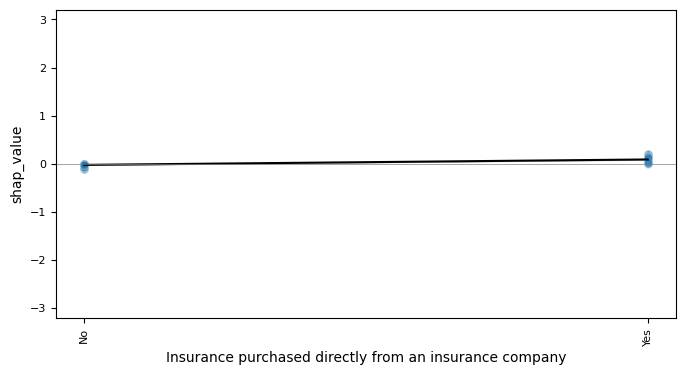

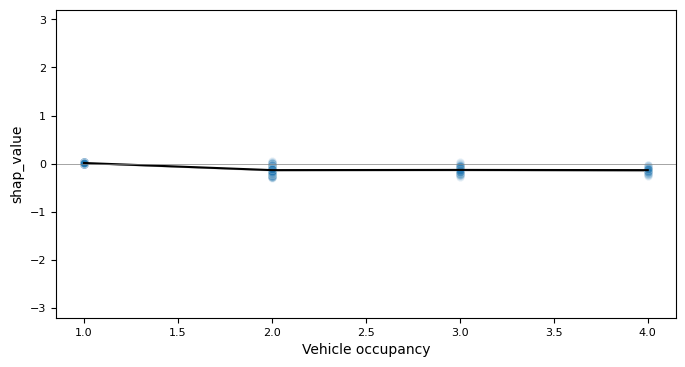

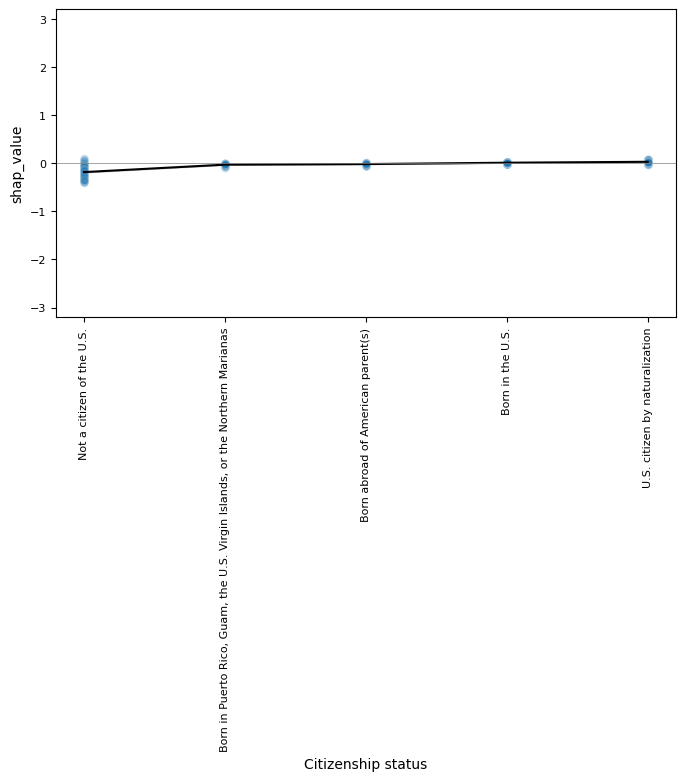

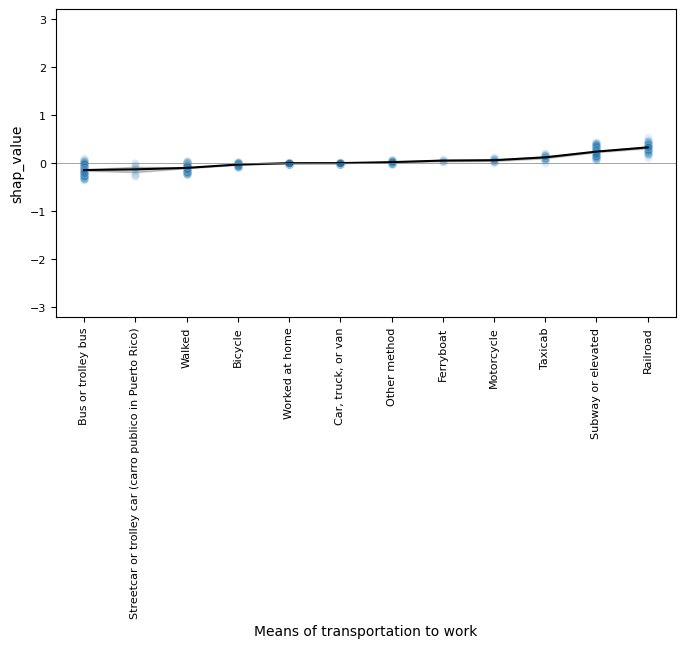

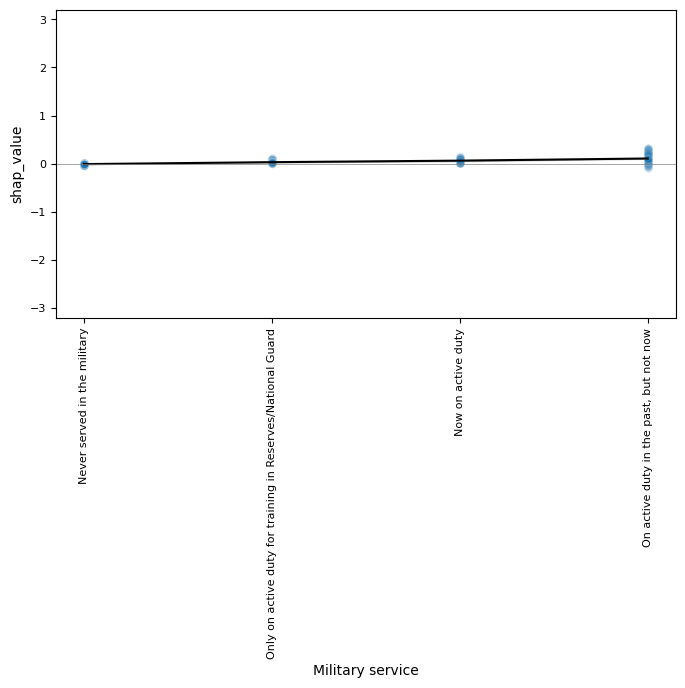

In [14]:
plot_shap_dependencies()

### Train-Synthetic-Explain-Synthetic

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


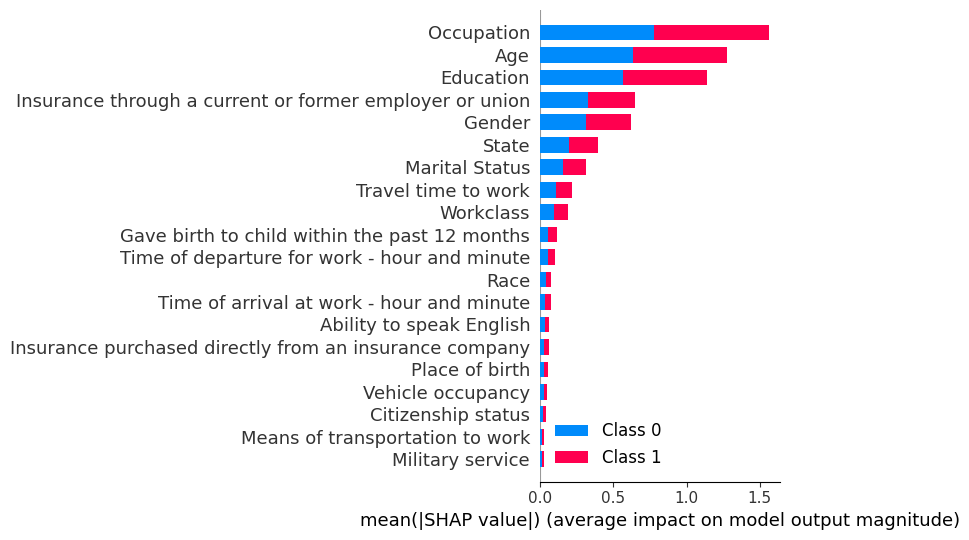

In [15]:
max_samples = 10_000
X_shap = X_syn.iloc[:max_samples]
y_shap = y_syn.iloc[:max_samples]
explainer = shap.TreeExplainer(model_syn)
shap_values = explainer.shap_values(X_shap)
probs_shap = model_syn.predict(X_shap)
shap.summary_plot(shap_values, X_shap, plot_size=0.2)

In [16]:
# sample with lowest probability
show_idx(np.argsort(probs_shap)[0])

Customer:    8260
Target:      0
Probability: 0.18%

##### Top 8 Attributes #####
Age                                                               18.0
Occupation                                                   EAT-Cooks
Education                                  Regular high school diploma
Gender                                                          Female
Marital Status                     Never married or under 15 years old
Means of transportation to work                                 Walked
Travel time to work                                                5.0
State                                                      Oklahoma/OK
Name: 8260, dtype: object



In [17]:
# sample with highest probability
show_idx(np.argsort(probs_shap)[-1])

Customer:    4597
Target:      1
Probability: 99.08%

##### Top 8 Attributes #####
Occupation                                                 MGR-Architectural And Engineering Managers
Education                                                                             Master's degree
Age                                                                                              48.0
Gender                                                                                           Male
Insurance through a current or former employer or union                                           Yes
State                                                                                     Maryland/MD
Marital Status                                                                                Married
Travel time to work                                                                              45.0
Name: 4597, dtype: object



In [18]:
# random sample
show_idx(100)

Customer:    100
Target:      1
Probability: 54.92%

##### Top 8 Attributes #####
Occupation                                                 OFF-Office Clerks, General
Age                                                                              63.0
Education                                                           Bachelor's degree
State                                                                Massachusetts/MA
Gender                                                                         Female
Travel time to work                                                              45.0
Insurance through a current or former employer or union                           Yes
Time of departure for work - hour and minute                   9:30 a.m. to 9:34 a.m.
Name: 100, dtype: object



In [19]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_shap.iloc[:1000,:], link="logit")

Occupation
Age
Education
Insurance through a current or former employer or union
Gender
State
Marital Status
Travel time to work
Workclass
Gave birth to child within the past 12 months
Time of departure for work - hour and minute
Race
Time of arrival at work - hour and minute
Ability to speak English
Insurance purchased directly from an insurance company
Place of birth
Vehicle occupancy
Citizenship status
Means of transportation to work
Military service


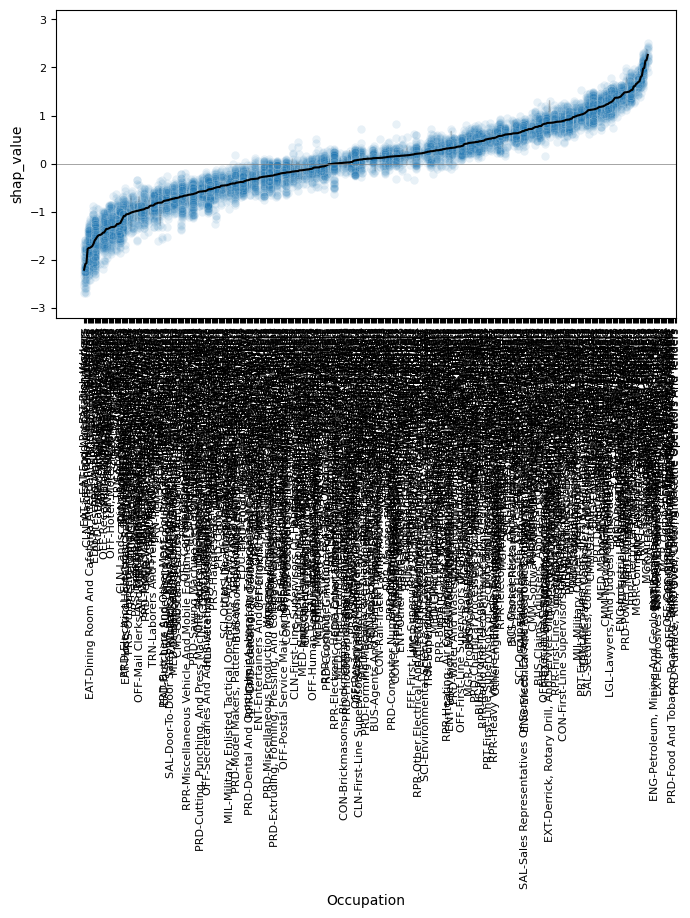

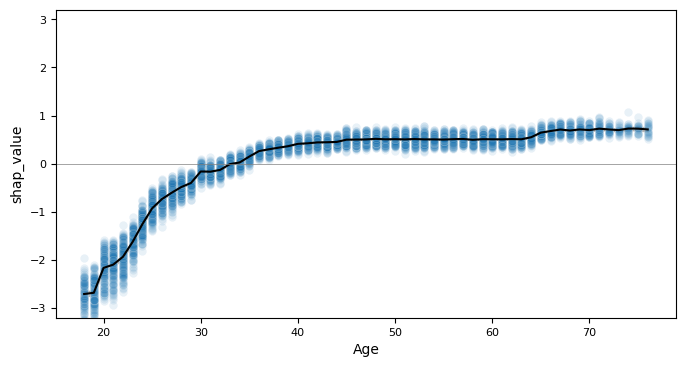

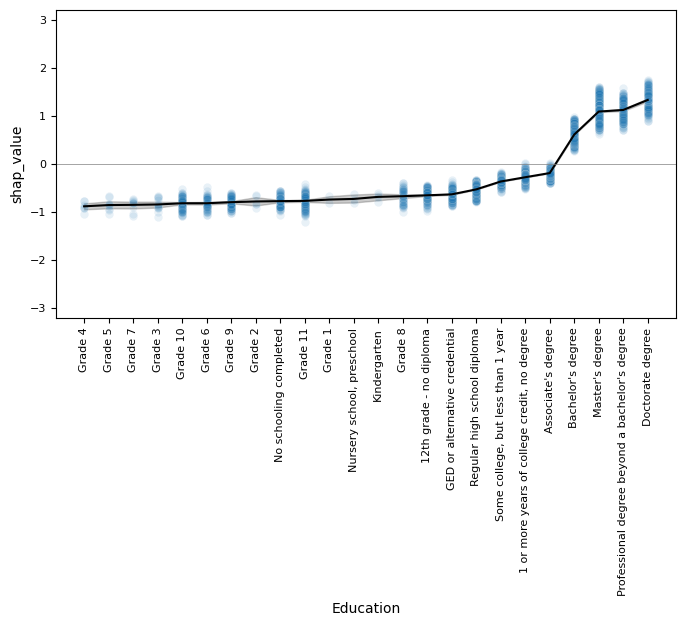

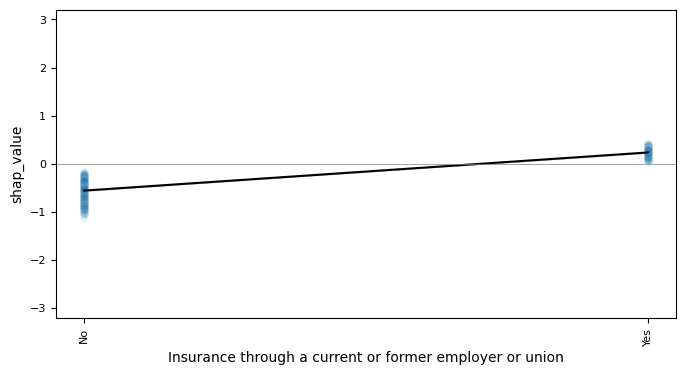

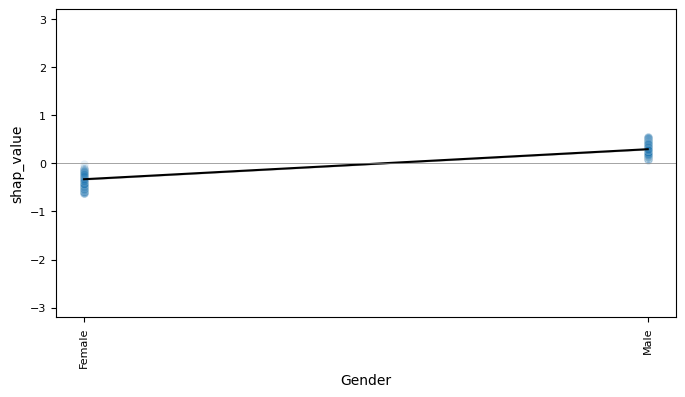

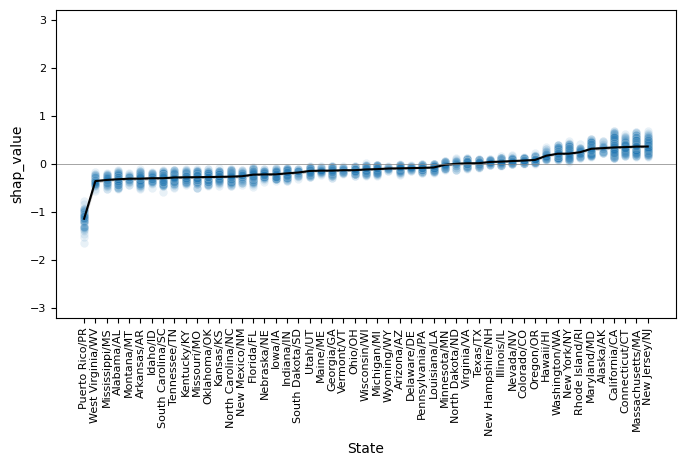

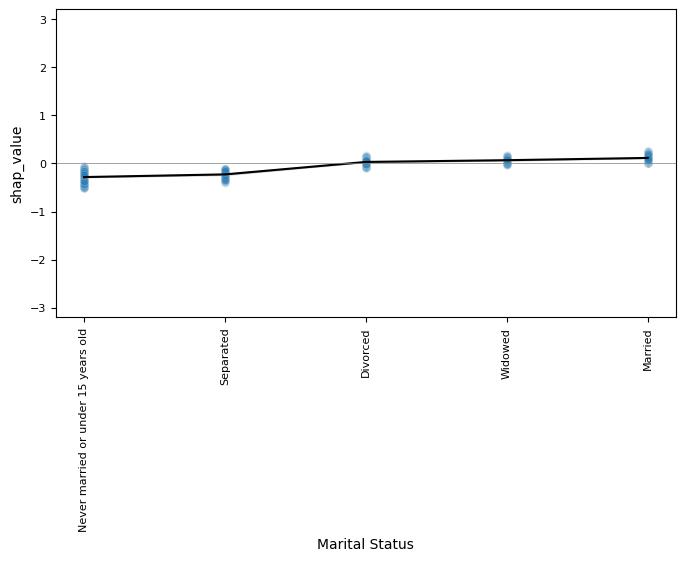

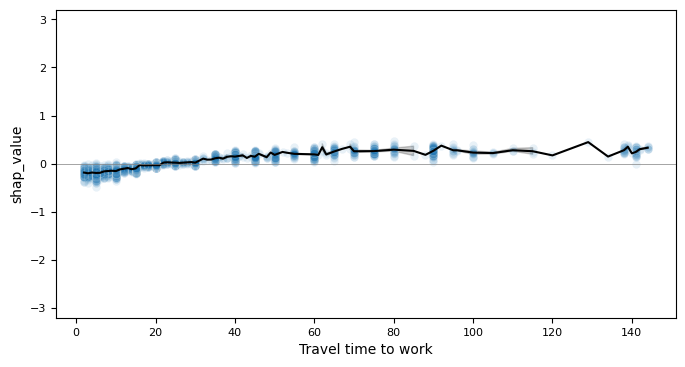

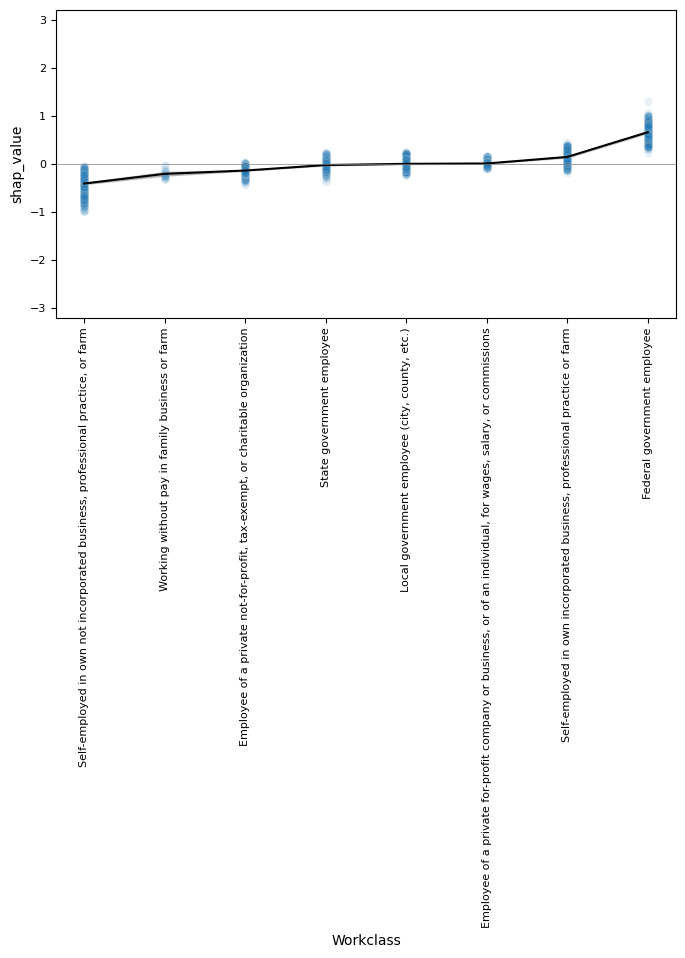

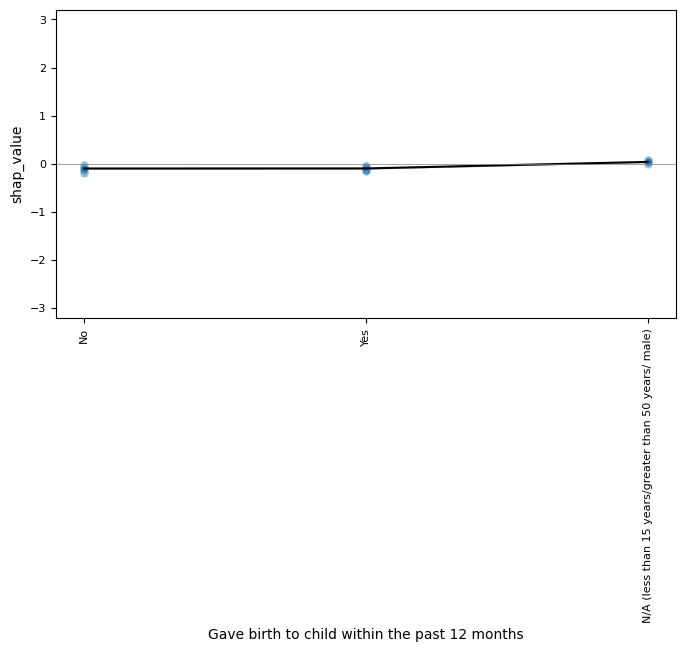

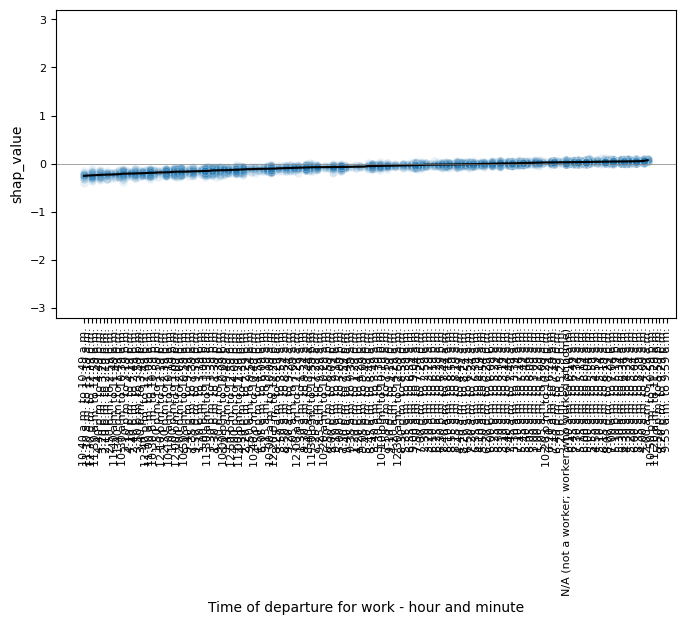

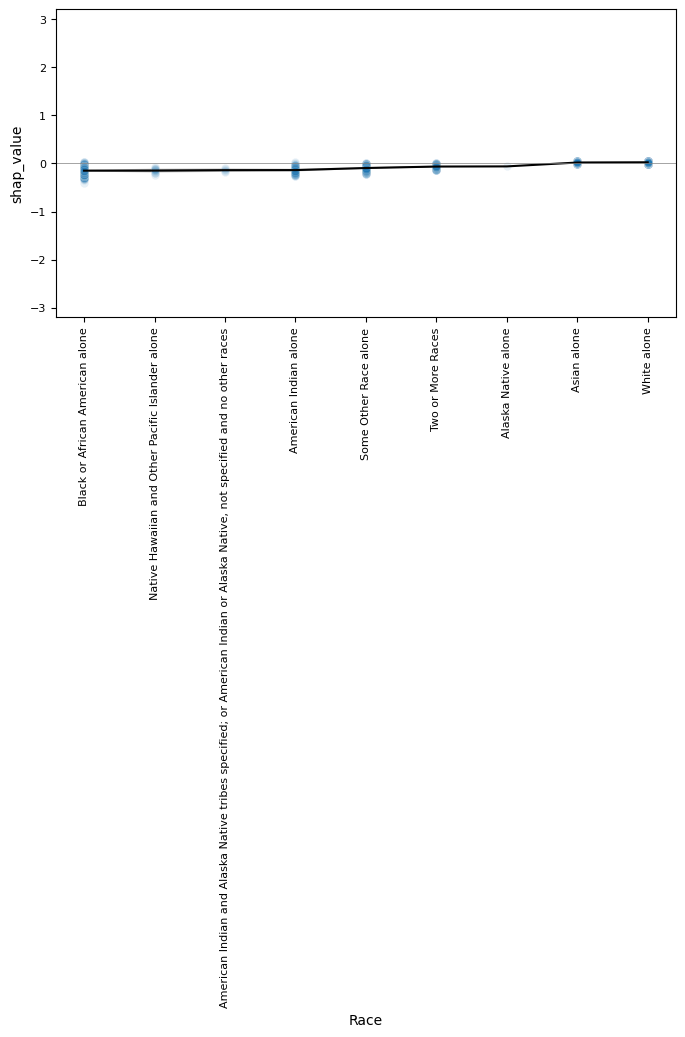

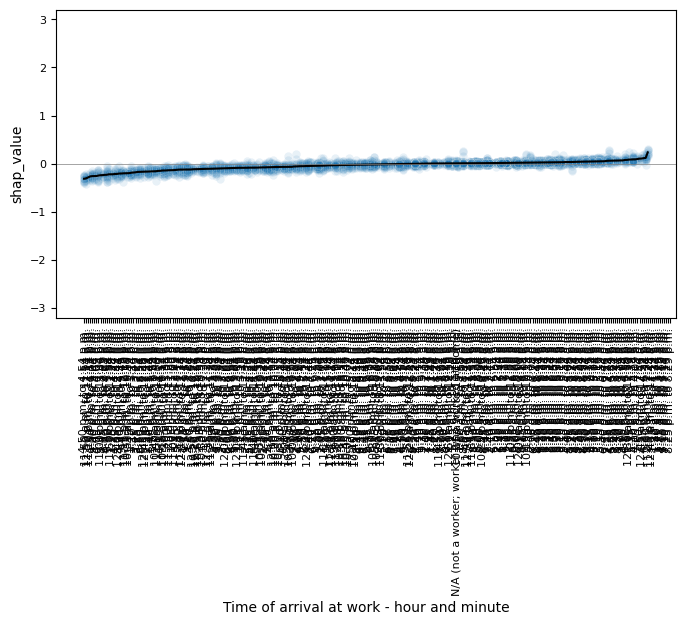

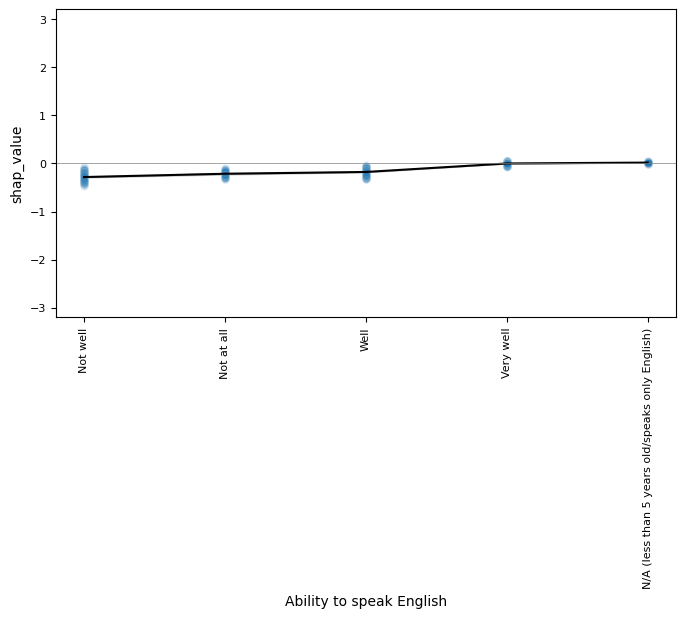

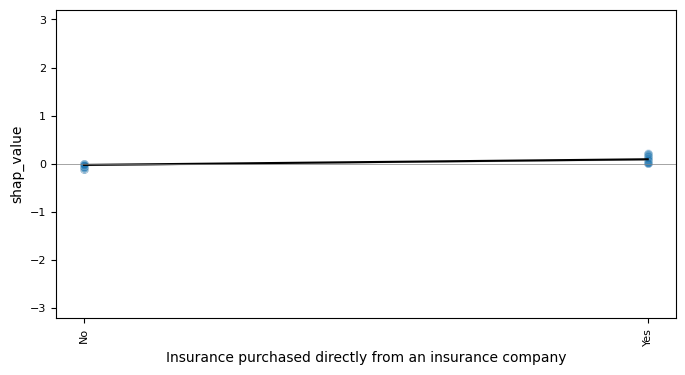

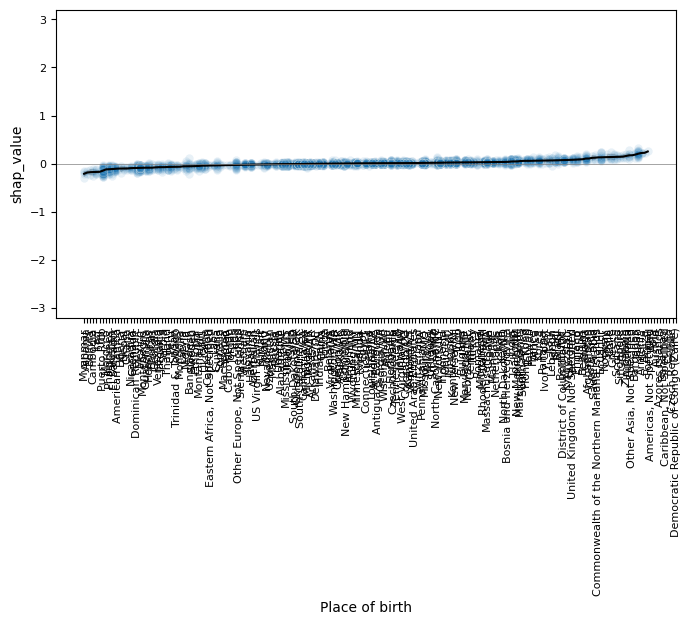

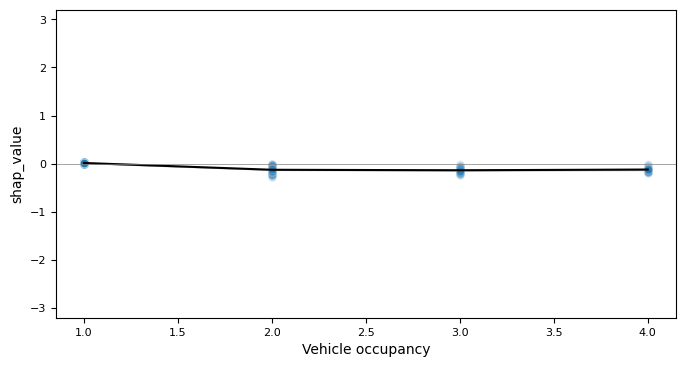

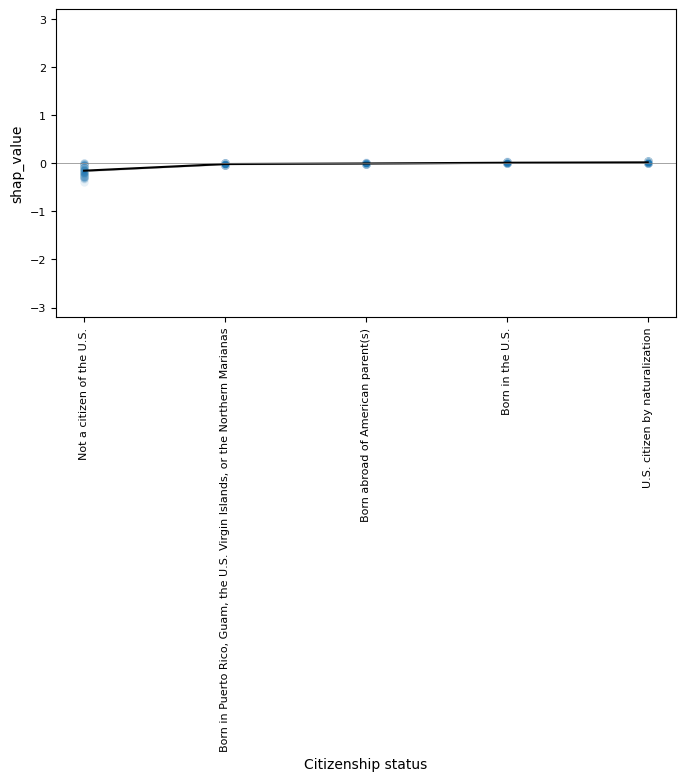

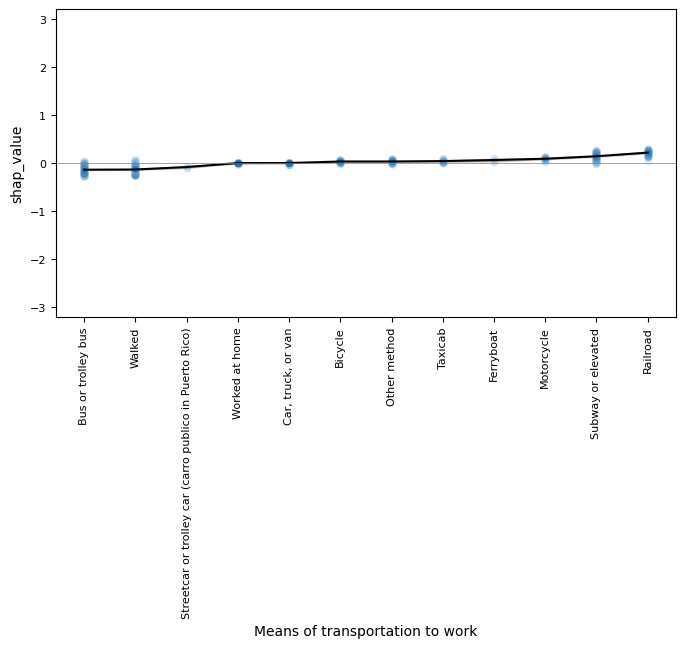

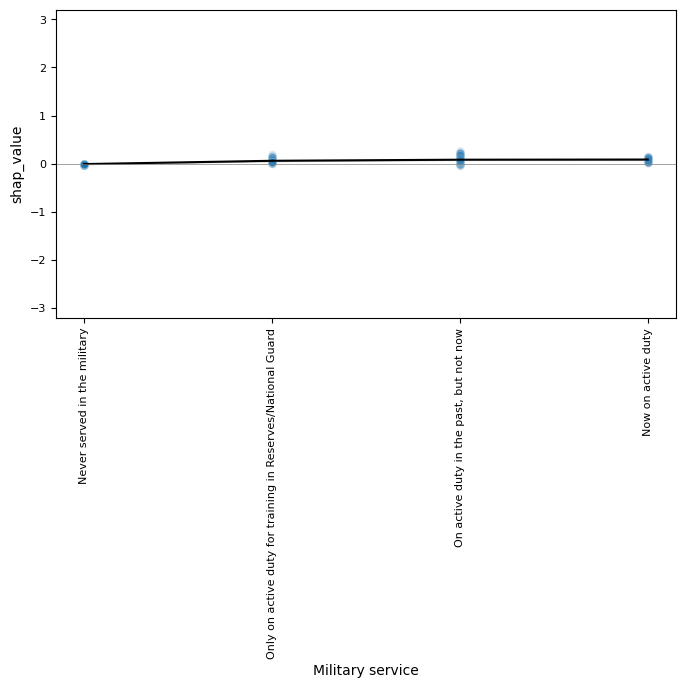

In [20]:
plot_shap_dependencies()